In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import ast
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.io import BlackrockIO
from nilearn import datasets, plotting

In [2]:
patient = 12

### First, get df_spikes (neur & spike times), df_trigs (event times), and df_psychopy (trial info)

### df_spikes

In [3]:
df_spikes = pd.read_csv(f'../../results/2025{patient}/records/df_spikes.csv')

# --- parser for numpy-style printed arrays stored as strings ---
def parse_spike_string(s):
    s = s.strip()[1:-1]       # remove surrounding brackets
    s = s.replace("...", "")  # remove ellipsis
    parts = s.split()         # split on whitespace
    return np.array(parts, dtype=float)

df_spikes['spikes'] = df_spikes['spikes'].apply(parse_spike_string)

eg_spikes = df_spikes['spikes'].iloc[0]
print("last 5 spikes (s):", eg_spikes[-5:])
print("last 5 spikes (min):", eg_spikes[-5:] / 60)

n_neurs = len(df_spikes)
df_spikes


last 5 spikes (s): [  23.6378       25.17166667 1600.95396667 1601.53736667 1601.88753333]
last 5 spikes (min): [ 0.39396333  0.41952778 26.68256611 26.69228944 26.69812556]


,chanID,clustID,spikes,#spikes,avgFR,region,x,y,z
0,97,612,"[18.08563333, 23.6378, 25.17166667, 1600.95396...",1062,0.670538,mLOFC1,-0.111605,40.172309,-15.682235
1,98,1583,"[4.07056667, 12.21563333, 12.36443333, 1620.53...",5454,3.372888,mLOFC2,-0.111605,42.570655,-15.682235
2,99,703,"[17.70213333, 21.48693333, 22.60946667, 25.521...",888,0.560458,mLOFC3,-0.111605,41.371482,-15.682235
3,100,683,"[20.34896667, 21.30346667, 25.88433333, 1602.8...",1044,0.652937,mLOFC4,-1.311382,40.172309,-15.682235
4,101,952,"[18.24433333, 20.95313333, 21.3368, 1599.64493...",1865,1.176957,mLOFC5,-1.311382,42.570655,-15.682235
5,102,2460,"[2.2395, 2.7039, 17.36813333, 1620.80353333, 1...",5565,3.437268,mLOFC6,-2.511159,42.570655,-15.682235
6,102,2475,"[21.89396667, 23.41096667, 32.29863333, 1619.8...",2432,1.520609,mLOFC6,-2.511159,42.570655,-15.682235
7,102,2477,"[18.13103333, 18.39366667, 18.5489, 1620.80773...",10843,6.764394,mLOFC6,-2.511159,42.570655,-15.682235
8,103,1466,"[17.21853333, 18.21083333, 18.4234, 1603.15746...",3834,2.406596,mLOFC7,-2.511159,40.172309,-15.682235
9,104,2349,"[5.8953, 13.2551, 17.28773333, 1620.19013333, ...",8883,5.499847,mLOFC8,-2.511159,41.371482,-15.682235


electrode locations

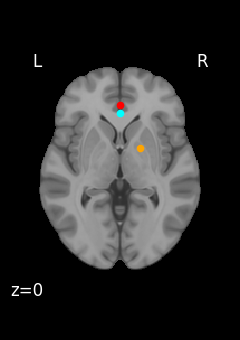

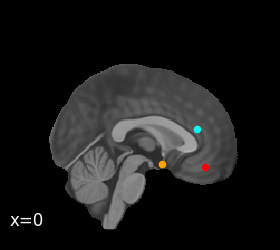

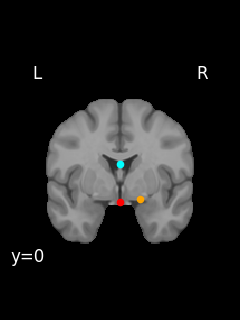

{'OFC': 'red', 'ACC': 'cyan', 'HIP': 'orange'}


In [4]:
template = datasets.load_mni152_template()

# grab most distal channels for each electrode
# IDs were different for older recording system (pt12)
if patient == 12: plot_chanIDs = [97, 105, 113]
else: plot_chanIDs = [193, 202, 210]

coords_list = []
for ch in plot_chanIDs:
    row = df_spikes[df_spikes['chanID'] == ch].iloc[0]   # first match
    coords_list.append([row.x, row.y, row.z])

coords = np.array(coords_list)

coord_regions  = ['OFC', 'ACC', 'HIP']
colors = {'OFC':'red', 'ACC':'cyan', 'HIP':'orange'}
marker_size = 20
# x = sagittal, y = coronal, z = axial

# 1. axial
# fix z (axial)
axial_cut = 0
coords_ax = coords.copy()
coords_ax[:,2] = axial_cut
disp1 = plotting.plot_anat(template, display_mode='z', cut_coords=[axial_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_ax, coord_regions):
    disp1.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])
    
# 2. sagittal (x=0)
sag1_cut = 0
coords_sag1 = coords.copy()
coords_sag1[:,0] = sag1_cut
disp2 = plotting.plot_anat(template, display_mode='x', cut_coords=[sag1_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_sag1, coord_regions):
    disp2.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

# 3. coronal (y=30)
cor_cut = 0
coords_cor = coords.copy()
coords_cor[:,1] = cor_cut
disp4 = plotting.plot_anat(template, display_mode='y', cut_coords=[cor_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_cor, coord_regions):
    disp4.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

plotting.show()

print(colors)

### df_trigs

In [5]:
# load

nev_file = glob.glob(f'../../results/2025{patient}/raw/*.nev')[0]
io = BlackrockIO(nev_file)
seg = io.read_block(lazy=False).segments[0]
dig_ev = [ev for ev in seg.events if "digital" in ev.name.lower()][0]

# map codes to labels
code_map = {
    10: "block started",
    20: "baseline started",
    30: "stim started",
    40: "delay started",
    50: "task started",
    51: "marker moved",
    52: "left pressed",
    53: "left released",
    54: "right pressed",
    55: "right released",
    56: "response submitted",
    60: "anticipation started",
    70: "feedback started",
    80: "block ended",
}

# build df
df_trigs_raw = pd.DataFrame({
    "trigger": dig_ev.labels.astype(int),
    "time": dig_ev.times.magnitude
})
df_trigs_raw["event"] = df_trigs_raw["trigger"].map(code_map)

df_trigs = df_trigs_raw[3:]
print(df_trigs.head(15))


    trigger       time                 event
3        10  36.379967         block started
4        20  70.978933      baseline started
5        30  71.864133          stim started
6        40  72.858367         delay started
7        50  74.342867          task started
8        51  75.375000          marker moved
9        52  75.375133          left pressed
10       53  75.974967         left released
11       56  76.374967    response submitted
12       60  76.375833  anticipation started
13       70  76.624967      feedback started
14       20  77.625233      baseline started
15       30  78.609500          stim started
16       40  79.608367         delay started
17       50  81.044033          task started


In [6]:
# checks
n_blocks = sum(df_trigs['event'] == 'block started')
n_stim = sum(df_trigs['event'] == 'stim started')
n_delay = sum(df_trigs['event'] == 'delay started')
n_task = sum(df_trigs['event'] == 'task started')
n_feedback = sum(df_trigs['event'] == 'feedback started')
print(n_blocks, n_stim, n_delay, n_task, n_feedback)


6 240 240 240 240


### df_psychopy

In [7]:
pts_df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
df_psych = pts_df.loc[pts_df['subj'] == str(patient)].reset_index(drop=True)
df_psych

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,Mcross.started,Mcross.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Unnamed: 122,Unnamed: 115,stim_ranks,resp_ranks
0,1.0,0.0,0.364,-0.0,0.02,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,38.0
1,1.0,0.0,0.352,-0.0,0.30,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.5,37.0
2,0.0,0.0,0.284,0.0,0.14,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.5,33.0
3,1.0,0.0,-0.280,-0.0,-0.30,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,9.0
4,1.0,0.0,0.304,-0.0,0.34,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.260,0.2,0.30,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,25.0
236,1.0,0.0,0.124,0.2,-0.18,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,15.0
237,1.0,0.0,0.252,0.2,0.38,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.5,23.5
238,1.0,0.0,0.320,0.2,0.14,0,1,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.5,37.0


In [8]:
df_psych['uncertainty'].value_counts()
pt_base = df_psych[df_psych['condition'] == 'baseline']
pt_gain_exp = df_psych[df_psych['condition'] == 'rew_comp']
pt_loss_exp = df_psych[df_psych['condition'] == 'pen_comp']
pt_base['uncertainty'].value_counts(), pt_gain_exp['uncertainty'].value_counts(), pt_loss_exp['uncertainty'].value_counts()

(uncertainty
 False    64
 True     16
 Name: count, dtype: int64,
 uncertainty
 False    48
 True     32
 Name: count, dtype: int64,
 uncertainty
 False    48
 True     32
 Name: count, dtype: int64)

### get spikes & rates within each epoch, for every neuron & trial

In [9]:
# bin params
size, dt = .02, .001

# epoch prestarts and durations
epochs = ['baseline', 'stim', 'delay', 'task', 'feedback']
epoch_prestarts, epoch_durs = {}, {}

# plot -.25s before onset for all epochs, -1s for task (response submission)
for epoch in epochs: epoch_prestarts[epoch] = 1 if epoch == 'task' else .25

# plot duration: 1.5 for delay, and 1s for the others, 0 for task (because we plot till onset=0 of anticipation) 
for epoch in epochs:
    if epoch == 'delay':
        epoch_durs[epoch] = 1.5
    elif epoch == 'task':
        epoch_durs[epoch] = 0
    else:
        epoch_durs[epoch] = 1

def get_normed_FRs(FRs, base_FRs):
    return FRs / base_FRs.mean(axis=(0, 2), keepdims=True)

def get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size=size, dt=dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in epoch window
        df_trigs: trig times 
        df_spikes: spike times per neur '''

    epoch_prestart = epoch_prestarts[epoch]
    epoch_dur = epoch_durs[epoch]

    # bin edges & centers for hists & plots
    bin_edges = np.arange(-epoch_prestart, epoch_dur + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & epoch_dur edges
    n_bins = len(bin_edges) - 1

    # a. get 240 START times of this epoch. then STOPS = STARTS + durations.
    epoch_start_rows = df_trigs[df_trigs['event'] == f'{epoch} started'].index
    epoch_starts = df_trigs.loc[epoch_start_rows, 'time'].values
    assert len(epoch_starts) == 240

    # b. since stop times of responses are variable,
    # get 240 STOP times of response, which is marked by 'anticipation started'. then STARTS = STOPS - durations (1).
    ant_start_rows = df_trigs[df_trigs['event'] == f'anticipation started'].index
    ant_starts = df_trigs.loc[ant_start_rows, 'time'].values
    assert len(ant_starts) == 240

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.empty((len(epoch_starts), len(df_spikes)), dtype=object)
    trial_neur_FRs = np.zeros((len(epoch_starts), len(df_spikes), n_bins))

    # for this particular epoch, grab spikes for each trial & neur 
    for trial_idx in range(len(epoch_starts)):

        for neur_idx, (_, neur_row) in enumerate(df_spikes.iterrows()):

            spike_train = np.zeros(n_bins)

            # 1. spikes within epoch (onset-prestart => onset+duration)

            if epoch != 'task': 
                trial_epoch_spikes = neur_row['spikes'][(neur_row['spikes'] >= epoch_starts[trial_idx] - epoch_prestart) &
                                                        (neur_row['spikes'] <= epoch_starts[trial_idx] + epoch_dur)]          
                trial_epoch_spikes = trial_epoch_spikes - epoch_starts[trial_idx] # align
            
            else: # response
                trial_epoch_spikes = neur_row['spikes'][(neur_row['spikes'] >= ant_starts[trial_idx] - epoch_prestart) &
                                                        (neur_row['spikes'] <= ant_starts[trial_idx] + epoch_dur)]          
                trial_epoch_spikes = trial_epoch_spikes - ant_starts[trial_idx] # align

            # 2. FRs within epoch
            # histogram counts → Hz
            counts, _ = np.histogram(trial_epoch_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt
            # smooth
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)

            # finally, store
            trial_neur_spikes[trial_idx, neur_idx] = trial_epoch_spikes
            trial_neur_FRs[trial_idx, neur_idx, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

# baseline spikes/FRs for norming
base_spikes, base_FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, 'baseline')

In [20]:
# print shapes
print("base_spikes: (trial * neurs):", base_spikes.shape)
# print 5 example spike trains for random trial and neur
for rand_trial, rand_neur in zip(np.random.randint(0, base_spikes.shape[0], size=5),
                                 np.random.randint(0, base_spikes.shape[1], size=5)):
    print(f"trial {rand_trial}, neur {rand_neur}:", base_spikes[rand_trial, rand_neur])


base_spikes: (trial * neurs): (240, 33)
trial 9, neur 31: [0.25066667]
trial 57, neur 28: []
trial 65, neur 27: []
trial 113, neur 20: []
trial 2, neur 5: []


In [11]:
def get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, trial_half, size=size, dt=dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in phase window
        clean_trigs_df: trig times 
        final_neur_df: spike times per neur '''
    
    if trial_half == '1st':
        phase = 'stim'
        phase_prestart = -.25 # considers last .25s of baseline and 1 + 1.5s + 1s of stim + delay + response
        phase_end = 3.5
    elif trial_half == '2nd':
        phase = 'feedback'
        phase_prestart = -1.25 # considers last 1s of response and .25 anticipation
        phase_end = 1
    else:
        raise ValueError("trial_half must be '1st' or '2nd'")

    # bin edges & centers for hists & plots
    bin_edges = np.arange(phase_prestart, phase_end + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & phase_end edges
    n_bins = len(bin_edges) - 1

    # get 240 start times of this phase
    phase_start_rows = clean_trigs_df[clean_trigs_df['event'] == f'{phase} started'].index
    phase_starts = clean_trigs_df.loc[phase_start_rows, 'time'].values
    assert len(phase_starts) == 240

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.empty((len(phase_starts), len(final_neur_df)), dtype=object)
    trial_neur_FRs = np.zeros((len(phase_starts), len(final_neur_df), n_bins))

    for trial_idx in range(len(phase_starts)):

        for neur_idx, (_, neur_row) in enumerate(final_neur_df.iterrows()):

            spike_train = np.zeros(n_bins)

            # 1. spikes within epoch

            trial_phase_spikes = neur_row['spikes'][(phase_starts[trial_idx] + phase_prestart <= neur_row['spikes']) &
                                                    (neur_row['spikes']                       <= phase_starts[trial_idx] + phase_end)]          
            trial_phase_spikes = trial_phase_spikes - phase_starts[trial_idx] # align

            # 2. FRs within epoch
            # histogram counts → Hz
            counts, _ = np.histogram(trial_phase_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt
            # smooth
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)

            # finally, store
            trial_neur_spikes[trial_idx, neur_idx] = trial_phase_spikes
            trial_neur_FRs[trial_idx, neur_idx, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

## create contrasts

In [12]:
def get_contrast_in_phase(clean_trigs_df, final_neur_df, subj_df, phase, contrast):
    ''' for particular contrast, in a particular phase, draw out spikes & FRs
        clean_trigs_df: trig times
        final_neur_df: spike times
        subj_df: trial info '''
    
    print(f'contrast: {contrast}, phase: {phase}')

    # get spikes/FRs for all trials/neurons in this phase
    spikes, FRs, bin_centers = get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, phase, size, dt)

    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, 'first_half', size, dt)
    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, 'second_half', size, dt)

    # storing trials and labels for each contrast
    cont_trials, cont_labels = [], []

    # stim contrasts
    if contrast =='context':
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
        cont_labels.append('gain')
        cont_labels.append('loss')
    # elif contrast =='stim':
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
    #     cont_labels.append('flat (curv) stims')
    #     cont_labels.append('curv (flat) stims')
    elif contrast =='difficulty':
        cont_trials.append(subj_df[~subj_df['difficulty']].index)
        cont_trials.append(subj_df[subj_df['difficulty']].index)
        cont_labels.append('easy')
        cont_labels.append('hard')

    # choice contrasts (median splits)
    elif contrast == 'resp_dir':
        cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
        cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
        cont_labels.append('right')
        cont_labels.append('left')
    elif contrast == 'normed_RT':
        median_rt = subj_df['normed_RT'].median()
        cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
        cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
        cont_labels.append('fast')
        cont_labels.append('slow')
    # elif contrast == 'dir_flip':
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
    #     cont_labels.append('not flipped')
    #     cont_labels.append('flipped')


    # outcome contrasts
    elif contrast == 'outcome':
        cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
        cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
        cont_labels.append('3 coins')
        cont_labels.append('1 coin')
        cont_labels.append('-1 coin')
        cont_labels.append('-3 coins')

    # condition contrast
    elif contrast == 'conditions':
        cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('gain_expanded')
        cont_labels.append('loss_expanded')
        cont_labels.append('baseline')
    elif contrast == 'baseline vs compressed conditions':
        cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('comp')
        cont_labels.append('base')

    # err
    else:
        raise ValueError('Invalid contrast')

    print('#trials should typically be 240/#contrasts')

    print('spikes (#trials, #neurs)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
    print('rates (#trials, #neurs, #bins)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

    return spikes, FRs, bin_centers, cont_trials, cont_labels


In [13]:
def get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast):
    ''' for particular contrast, in a particular phase, draw out spikes & FRs
        clean_trigs_df: trig times
        final_neur_df: spike times
        subj_df: trial info '''
    
    print(f'contrast: {contrast}, trial_half: {trial_half}')

    # get spikes/FRs for all trials/neurons in this trial_half
    spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, trial_half, size, dt)

    # storing trials and labels for each contrast
    cont_trials, cont_labels = [], []

    # stim contrasts
    if contrast =='context':
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
        cont_labels.append('gain')
        cont_labels.append('loss')
    # elif contrast =='stim':
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
    #     cont_labels.append('flat (curv) stims')
    #     cont_labels.append('curv (flat) stims')
    elif contrast =='difficulty':
        cont_trials.append(subj_df[~subj_df['difficulty']].index)
        cont_trials.append(subj_df[subj_df['difficulty']].index)
        cont_labels.append('easy')
        cont_labels.append('hard')

    # choice contrasts (median splits)
    elif contrast == 'resp_dir':
        cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
        cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
        cont_labels.append('right')
        cont_labels.append('left')
    elif contrast == 'normed_RT':
        median_rt = subj_df['normed_RT'].median()
        cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
        cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
        cont_labels.append('fast')
        cont_labels.append('slow')
    # elif contrast == 'dir_flip':
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
    #     cont_labels.append('not flipped')
    #     cont_labels.append('flipped')


    # outcome contrasts
    elif contrast == 'outcome':
        cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
        cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
        cont_labels.append('3 coins')
        cont_labels.append('1 coin')
        cont_labels.append('-1 coin')
        cont_labels.append('-3 coins')

    # condition contrast
    elif contrast == 'conditions':
        cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('gain_expanded')
        cont_labels.append('loss_expanded')
        cont_labels.append('baseline')
    elif contrast == 'baseline vs compressed conditions':
        cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('comp')
        cont_labels.append('base')

    # err
    else:
        raise ValueError('Invalid contrast')

    print('#trials should typically be 240/#contrasts')

    print('spikes (#trials, #neurs)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
    print('rates (#trials, #neurs, #bins)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

    return spikes, FRs, bin_centers, cont_trials, cont_labels


### plots

a. check rasters

/tmp/ipykernel_2318946/2725271931.py:21: RuntimeWarning: divide by zero encountered in divide
  return FRs / base_FRs.mean(axis=(0, 2), keepdims=True)
/tmp/ipykernel_2318946/2725271931.py:21: RuntimeWarning: invalid value encountered in divide
  return FRs / base_FRs.mean(axis=(0, 2), keepdims=True)


NameError: name 'neur_spikes_df' is not defined

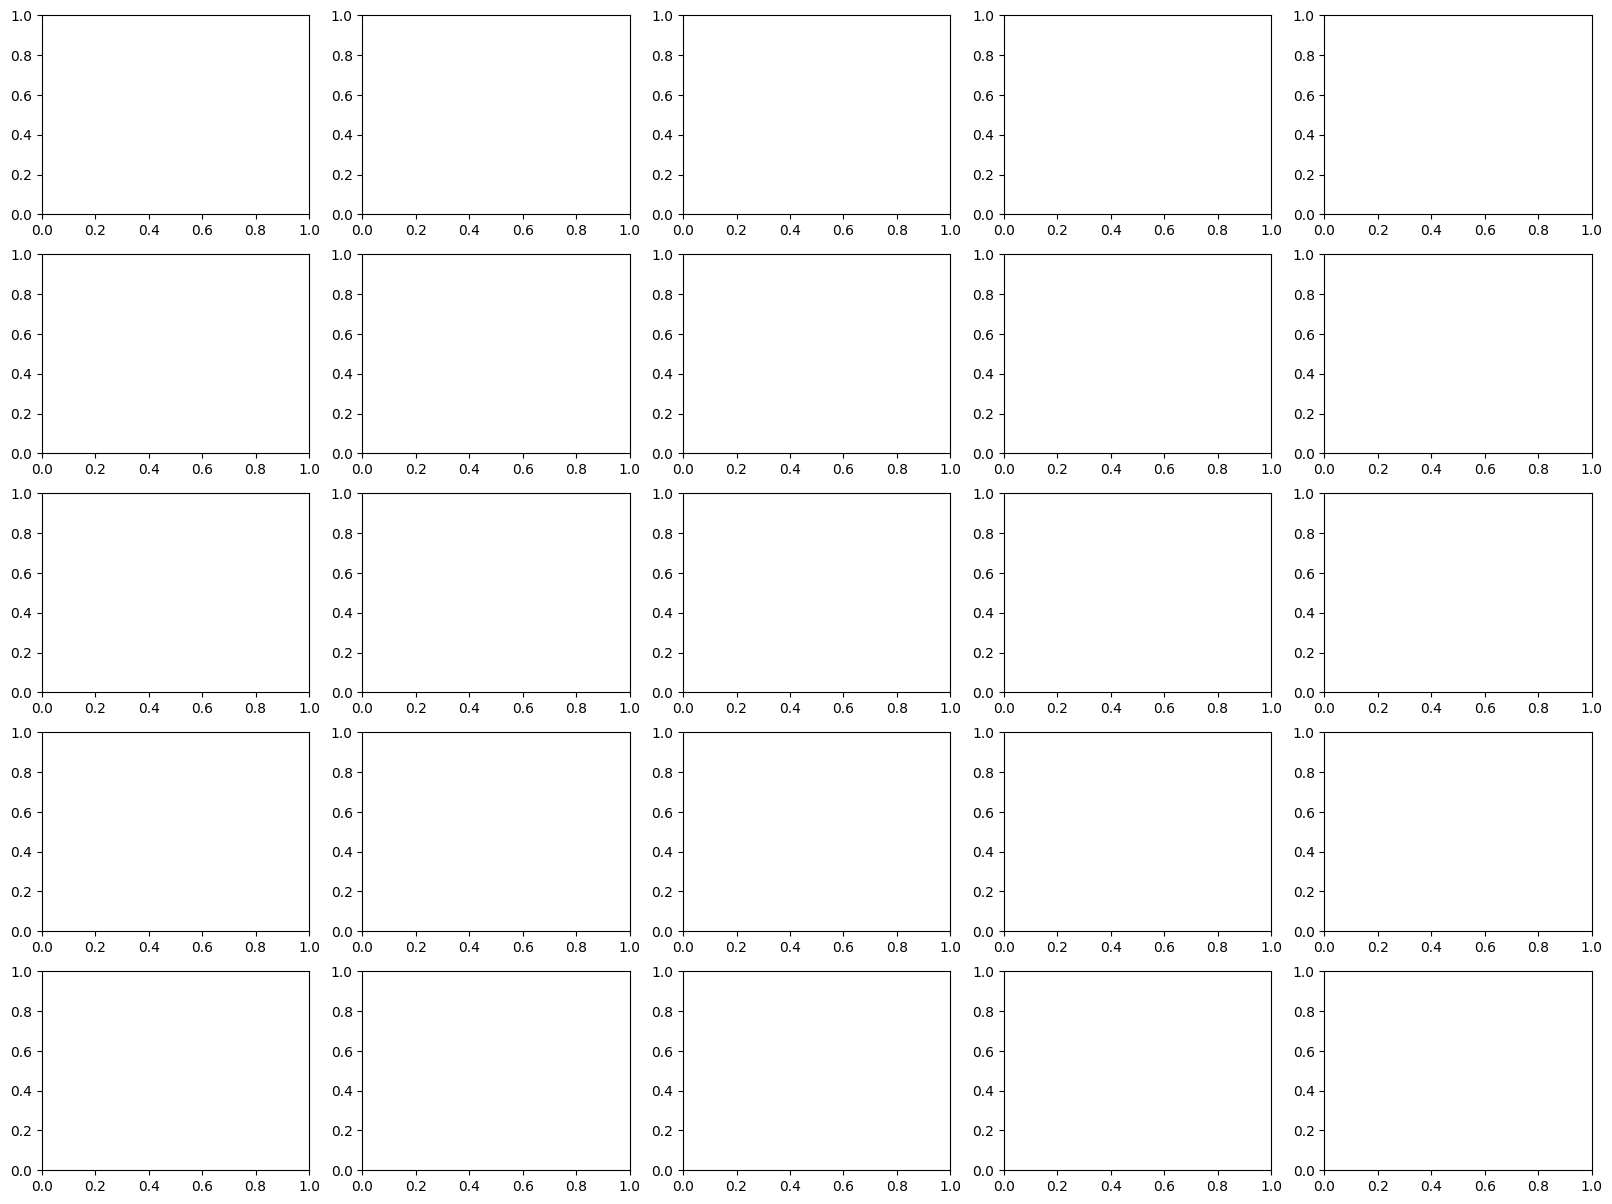

In [14]:
epoch = 'task'
spikes, FRs, bin_centers = get_epoch_spikes_and_FRs(df_trigs, df_spikes, epoch, size, dt)
normed_FRs = get_normed_FRs(FRs, base_FRs)

n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_id in range(n_neurs):
    axs[ax].eventplot(spikes[:, neur_id], orientation='horizontal', colors='k', alpha=0.3, linewidths=1., linelengths=3.)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron, id={neur_id}',
                ylabel='trial', xlabel=f'time from {epoch} onset (s)', xlim=[epoch_prestarts[epoch], epoch_ends[epoch]])
    ax += 1

plt.suptitle(epoch, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


b. contrasts

In [ ]:
# phases = ['baseline', 'stim', 'task', 'delay', 'feedback']
# contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
phase, contrast = 'task', 'context'
spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_phase(clean_trigs_df, final_neur_df, subj_df, phase, contrast)
normed_FRs = get_normed_FRs(FRs, base_FRs)

In [ ]:
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0
colors = ['b', 'r', 'g', 'k']

for neur_id in range(n_neurs):
    if neur_id in dropped_neur_ids: continue

    for idx in range(len(cont_labels)):

        cont_label, cont_trial, cont_color = cont_labels[idx], cont_trials[idx], colors[idx]

        data = normed_FRs[cont_trial, neur_id, :]

        mu = data.mean(axis=0)
        sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
        axs[ax].plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
        axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

    # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} onset (s)',
                xticks=np.linspace(phase_prestarts[phase], phase_ends[phase], 6), xlim=[phase_prestarts[phase], phase_ends[phase]], ylim=[0, 2])
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# get unique rowID where region = 'mLACC5'. there might be multiple
reg = 'mLACC5'
neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]

# 1. raster
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_id]} neuron')

# 1. raster
# create list of trials by contrast and corresponding color
raster_trial_list, color_trial_list = [], []
# for indx in range(len(cont_labels)):
for indx in [1,0]:
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
    raster_trial_list.extend(list(spikes[cont_trial, neur_id]))
    color_trial_list.extend([cont_color] * len(cont_trial))

plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.eventplot(raster_trial_list, orientation='horizontal', colors=color_trial_list, linewidths=1.0, linelengths=3.0)
plt.ylabel('sorted trials')
plt.xlabel(f'time from\n{phase} onset (s)')
plt.xlim([phase_prestarts[phase], phase_ends[phase]])
plt.show()

# 2. psth
plt.figure(figsize=(4,3))

for indx in range(len(cont_labels)):
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

    data = normed_FRs[cont_trial, neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    plt.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

plt.ylabel('normed FR (Hz)')
plt.xlabel(f'time from\n{phase} onset (s)')
plt.xlim([phase_prestarts[phase], phase_ends[phase]])
plt.ylim([.25, 1.75])
plt.legend(handles=[plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
                    for idx in range(len(cont_labels))], loc='upper right')
plt.show()


## sfn

In [ ]:
# phases = ['baseline', 'stim', 'task', 'delay', 'feedback']
# contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
trial_half, contrast = '2nd', 'context'
spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast)
normed_FRs = get_normed_FRs(FRs, base_FRs)

In [ ]:
# get unique rowID where region = 'mLACC5'. there might be multiple
reg = 'mLACC5'
neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]
colors = ['b', 'r', 'g', 'k']

# create figure with two subplots (stacked vertically)
width = 10 if trial_half == '1st' else 6
fig, axs = plt.subplots(2, 1, figsize=(width, 6), sharex=True,
                        gridspec_kw={'height_ratios': [1, 1]})  # equal height

# ---------------------------------------------
# 1. RASTER
# ---------------------------------------------
# --- Raster as dots instead of lines ---
ax = axs[0]

trial_counter = 0
for indx in [1, 0]:
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
    
    for t_i, trial_idx in enumerate(cont_trial):
        spike_times = spikes[trial_idx, neur_id]
        ax.scatter(spike_times, 
                   np.ones_like(spike_times)*trial_counter, 
                   s=4, color=cont_color, alpha=.8)  # s = marker size
        trial_counter += 1

ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_ylabel('sorted trials')
if trial_half == '1st': ax.set_title('Aligned to stimulus')
elif trial_half == '2nd': ax.set_title('Aligned to outcome')

# ---------------------------------------------
# 2. PSTH
# ---------------------------------------------
ax = axs[1]
for indx in range(len(cont_labels)):
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

    data = normed_FRs[cont_trial, neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    ax.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
    ax.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_ylabel('normed FR (Hz)')
ax.set_ylim([0, 1.75])

# ax.set_xlabel(f'time from {phase} onset (s)')
if trial_half == '1st':
    ax.set_xlim([-.25, 3.5])
    for ax in axs:
        ax.axvline(1, color='k', linestyle='--', alpha=0.5) # end of response
        ax.axvline(2.5, color='k', linestyle='--', alpha=0.5) # end of response
elif trial_half == '2nd':
    ax.set_xlim([-1.25, 1])
    for ax in axs:
        ax.axvline(-.25, color='k', linestyle='--', alpha=0.5) # end of response

# legend
handles = [plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
            for idx in range(len(cont_labels))]
ax.legend(handles=handles, loc='lower right')

for ax in axs:
    ax.tick_params(direction='in', length=4, width=1)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
# fig.savefig('../../results/figs/sfn/fig4a_real_neur.eps', format='eps', dpi=300)
plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
fig.savefig(f'../../results/figs/sfn/fig4a_trial_{trial_half}_half.svg', format='svg', dpi=300)



c. phase neurons

In [ ]:
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):

    if neur_i in dropped_neur_ids: continue
    # no norming for baseline itself
    data = normed_FRs[:, neur_i, :] if phase!='baseline' else FRs[:, neur_i, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    axs[ax].plot(bin_centers, mu, alpha=0.9)
    axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
    # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} onset (s)',
                xticks=np.linspace(phase_prestarts[phase], phase_ends[phase], 6), xlim=[phase_prestarts[phase], phase_ends[phase]])
    if phase!='baseline': axs[ax].set(ylim=[0, 2])
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


zifest

In [ ]:
# plt.rcParams.update({
#     "axes.titlesize": 20,   # subplot titles
#     "axes.labelsize": 18,   # x/y labels
#     "xtick.labelsize": 16,  # x ticks
#     "ytick.labelsize": 16,  # y ticks
#     "legend.title_fontsize": 16,  # legend title
#     "legend.fontsize": 16,        # legend labels
# })

duration checks for stim & feedback

In [ ]:
# n_rows, n_cols = 1, 2
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# print(len(subj_df['no_resp_text.started']))
# axs[ax].hist(subj_df['no_resp_text.started']-subj_df['feedback.started'], bins=30)
# axs[ax].set_title('no_resp_text.started - feedback.started (s)')
# ax += 1

# axs[ax].hist(subj_df['target_stim.started']-subj_df['stim.started'], bins=30)
# axs[ax].set_title('target_stim.started - stim.started (s)')

# plt.suptitle('duration checks')
# plt.tight_layout()
# plt.show()